In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
original_df = pd.read_csv('CreditDataset.csv')
original_df.head()
target = 'Home'
missing_values = [99999999, 'NaN']

In [3]:
def extract_target_variable(df, target):
    return df[target]
def without_target_variable(df, target):
    return df.drop(target, axis=1)

In [4]:
target_variable = extract_target_variable(original_df, target)
dataSet = without_target_variable(original_df, target)

In [5]:
print(dataSet.index)

RangeIndex(start=0, stop=4040, step=1)


In [6]:
def remove_objects_with_missing_values(df, missing_values):
    return df[(df != missing_values).all(axis=1)].copy()

In [7]:
print(dataSet.index)

RangeIndex(start=0, stop=4040, step=1)


In [8]:
clean_df = remove_objects_with_missing_values(dataSet, 99999999)
print(clean_df.shape)

(4040, 12)


In [9]:
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from tqdm import trange

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def compute_grid_search_results(estimator, param_grid, X, Y, cv=KFold(5)):
    grid_search = GridSearchCV(
        estimator=estimator, 
        param_grid=param_grid,
        scoring=make_scorer(accuracy_score),
        cv=cv
    )
    grid_search.fit(X, Y) 
    return pd.DataFrame(grid_search.cv_results_)


def insert_min_max_score_per_fold(cv_df):
#     split_score_names = ["split{}_test_score".format(i) for i in range(5)]
#     cv_df['min_test_score'] = cv_df[split_score_names].min(axis=1)
#     cv_df['max_test_score'] = cv_df[split_score_names].max(axis=1)
    mean_test_score=cv_df['mean_test_score']
    test_score_std =cv_df['std_test_score']
    cv_df['min_test_score'] = mean_test_score-test_score_std
    cv_df['max_test_score'] = mean_test_score+test_score_std
    return cv_df


def print_best_score(cv_df, estimator_name, param_name):
    param_column_name = "param_{}".format(param_name)
    best_row_index = cv_df['mean_test_score'].idxmax()
    best_row = cv_df.loc[best_row_index,:]
    best_score_value = best_row['mean_test_score']
    best_param = best_row[param_column_name]
    format_args = (estimator_name, best_score_value, param_name, best_param)
    print("Лучшая оценка для {}: {:.2f} (когда {} = '{}')".format(*format_args))
    
    
def plot_numeric_grid_search_results(cv_df, estimator_name, param_name, ax=None):
    param_column_name = "param_{}".format(param_name)
    param_values = cv_df[param_column_name].values.astype(np.int)
    mean_test_score = cv_df['mean_test_score'].values
    min_test_score = cv_df['min_test_score'].values
    max_test_score = cv_df['max_test_score'].values
    if ax is None:
        fig, ax = plt.subplots(figsize = (12,8))
    ax.grid()
    fontsize=16
    ax.plot(param_values, mean_test_score, 'o-', color='b')
    ax.fill_between(param_values, min_test_score, max_test_score, alpha=0.1, color="g")
    ax.set_title("График оценки на кросс-валидации для {} от {}".format(estimator_name, param_name), fontsize=fontsize)
    ax.set_ylabel("Оценка на кросс-валидации (ROC_AUC)", fontsize=fontsize)
    ax.set_xlabel("Значение гиперпараметра {}".format(param_name), fontsize=fontsize)
    return ax


def plot_discrete_grid_search_results(cv_df, estimator_name, param_name, ax=None):
    mean_test_score = cv_df['mean_test_score'].values
    param_column_name = "param_{}".format(param_name)
    split_score_names = ["split{}_test_score".format(i) for i in range(5)]
    split_score_names.append(param_column_name)
    cv_df = cv_df[split_score_names]
    cv_df = cv_df.set_index(param_column_name)
    cv_df = cv_df.transpose()
    cv_df = cv_df.reset_index(drop=True)
    if ax is None:
        fig, ax = plt.subplots(figsize = (12,8))
    ax.grid()
    fontsize=16
    ax.set_title("График оценки на кросс-валидации для {} от {}".format(estimator_name, param_name), fontsize=fontsize)
    ax.set_ylabel("Оценка на кросс-валидации (ROC_AUC)", fontsize=fontsize)
    ax.set_xlabel("Значение гиперпараметра {}".format(param_name), fontsize=fontsize)
    cv_df.boxplot(ax=ax)
    return ax
    
    
def launch_grid_search(estimator, estimator_name, param_name, param_values, X, Y, numeric, ax=None):
    params = {param_name: param_values}
    cv_df = compute_grid_search_results(estimator, params, X, Y)
    print_best_score(cv_df, estimator_name, param_name)
    if numeric:
        cv_df = insert_min_max_score_per_fold(cv_df)
        ax = plot_numeric_grid_search_results(cv_df, estimator_name, param_name, ax)
    else:
        ax = plot_discrete_grid_search_results(cv_df, estimator_name, param_name, ax)
    return cv_df, ax

In [11]:
target_variable.unique()

array([1, 2, 5, 3, 6, 4], dtype=int64)

Лучшая оценка для KNN: 0.67 (когда n_neighbors = '33')


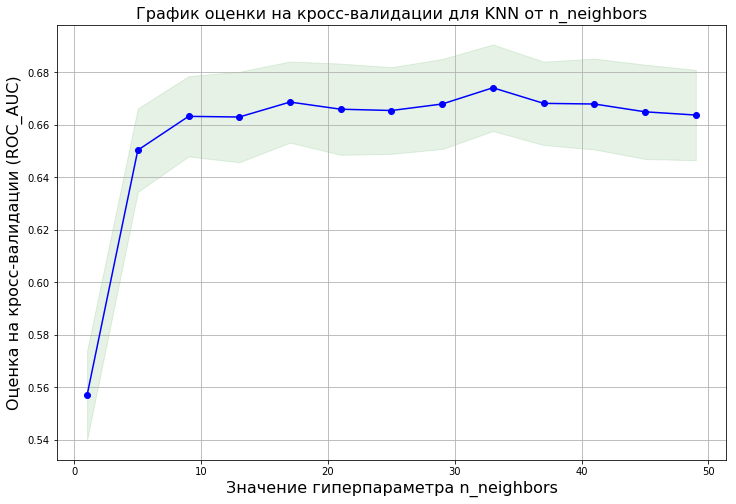

In [12]:
with warnings.catch_warnings(record=True):
    knn_first_grid_df, ax=launch_grid_search(
        estimator=KNeighborsClassifier(),
        estimator_name="KNN",
        param_name='n_neighbors',
        param_values=[x for x in range(1, 50, 4)],
        X = dataSet,
        Y = target_variable.values,
        numeric=True
    );

Лучшая оценка для DecisionTree: 0.77 (когда max_depth = '7')


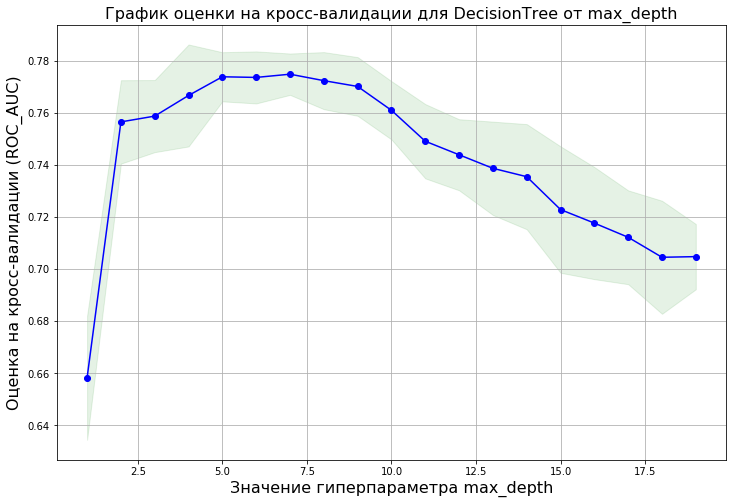

In [128]:
with warnings.catch_warnings(record=True):
    tree_first_grid_df, ax = launch_grid_search(
        estimator=DecisionTreeClassifier(),
        estimator_name="DecisionTree",
        param_name='max_depth',
        param_values=[x for x in range(1, 20)],
        X = dataSet,
        Y = target_variable.values,
        numeric=True
    );

In [106]:
loss_values=[
    'hinge',
    'log',
    'modified_huber',
    'squared_hinge',
    'perceptron'
]

Лучшая оценка для SGD: 0.59 (когда loss = 'perceptron')


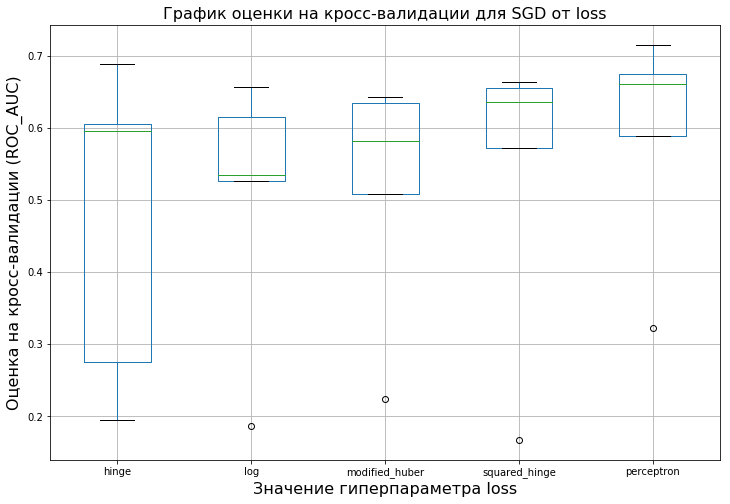

In [129]:
with warnings.catch_warnings(record=True):
    sgd_first_grid_df, ax = launch_grid_search(
        estimator=SGDClassifier(),
        estimator_name="SGD",
        param_name='loss',
        param_values=loss_values,
        X = dataSet,
        Y = target_variable.values,
        numeric=False
    );

In [108]:
def print_highest_std_after_first_grid():
    first_grid_results = {
        "KNN":knn_first_grid_df,
        "DecisionTree":tree_first_grid_df,
        "SGD":sgd_first_grid_df
    }
    for name, result_df in first_grid_results.items():
        mean_std = result_df['std_test_score'].mean()
        print("Среднее значение доверительного интервала для {} равно {:.4f}".format(name, mean_std))
    
print_highest_std_after_first_grid()

Среднее значение доверительного интервала для KNN равно 0.0167
Среднее значение доверительного интервала для DecisionTree равно 0.0154
Среднее значение доверительного интервала для SGD равно 0.1710


In [ ]:
Нормирование вещественных парметров

In [13]:
original_df.head()

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,0,1,36,26,1,1,1,46,107,0,0,310,910


In [14]:
def extract_numeric_features(df):
    numeric_features_names = ['Seniority', 'Time', 'Age', 'Records', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price']
    return df[numeric_features_names]

In [15]:
numeric_df = extract_numeric_features(original_df)
numeric_df.head()

,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price
0,9,60,30,1,73,129,0,0,800,846
1,17,60,58,1,48,131,0,0,1000,1658
2,10,36,46,2,90,200,3000,0,2000,2985
3,0,60,24,1,63,182,2500,0,900,1325
4,0,36,26,1,46,107,0,0,310,910


In [16]:
with warnings.catch_warnings(record=True):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df))
    scaled_numeric_df.columns = numeric_df.columns
scaled_numeric_df.head()

,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price
0,0.104111,0.911650,-0.630474,-0.443089,0.887712,-0.157684,-0.541940,-0.313101,-0.501621,-0.997403
1,1.085698,0.911650,1.910470,-0.443089,-0.404650,-0.132884,-0.541940,-0.313101,-0.065864,0.344176
2,0.226810,-0.738839,0.821494,2.256882,1.766519,0.722725,-0.220675,-0.313101,2.112924,2.536635
3,-1.000174,0.911650,-1.174962,-0.443089,0.370767,0.499523,-0.274219,-0.313101,-0.283742,-0.206003
4,-1.000174,-0.738839,-0.993466,-0.443089,-0.508039,-0.430487,-0.541940,-0.313101,-1.569227,-0.891663


Лучшая оценка для KNN: 0.64 (когда n_neighbors = '17')


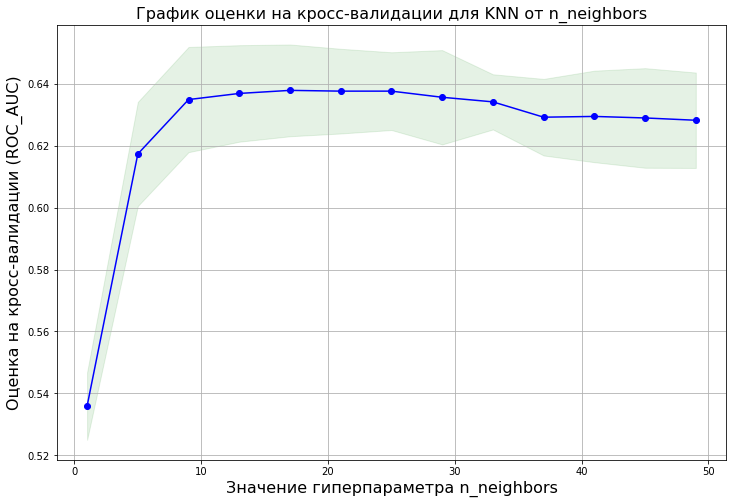

In [17]:
with warnings.catch_warnings(record=True):
    launch_grid_search(
        estimator=KNeighborsClassifier(),
        estimator_name="KNN",
        param_name='n_neighbors',
        param_values=[x for x in range(1, 50, 4)],
        X = scaled_numeric_df.values,
        Y = target_variable.values,
        numeric=True
    );

Лучшая оценка для SGD: 0.62 (когда loss = 'log')


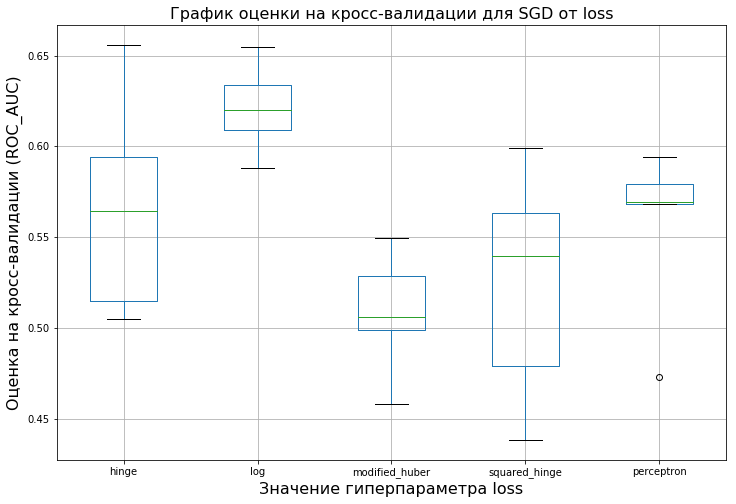

In [131]:
with warnings.catch_warnings(record=True):
    launch_grid_search(
        estimator=SGDClassifier(),
        estimator_name="SGD",
        param_name='loss',
        param_values=loss_values,
        X = scaled_numeric_df.values,
          Y = target_variable.values,
        numeric=False
    );

Лучшая оценка для DecisionTree: 0.78 (когда max_depth = '7')


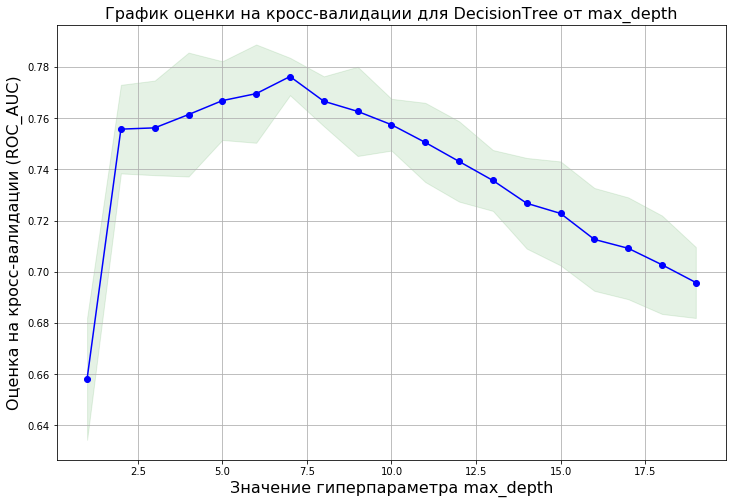

In [132]:
with warnings.catch_warnings(record=True):
    launch_grid_search(
        estimator=DecisionTreeClassifier(),
        estimator_name="DecisionTree",
        param_name='max_depth',
        param_values=[x for x in range(1, 20)],
        X = scaled_numeric_df.values,
        Y = target_variable.values,
        numeric=True
    );

# Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:

KNN — число соседей (n_neighbors) и метрика (metric)
DecisonTree — глубина дерева (max_Qdepth) и критерий разбиения (criterion)
RandomForest — критерий разбиения в деревьях (criterion) и максимальное число рассматриваемых признаков (max_features); используйте найденное ранее каличество деревьев
SGDClassifier — оптимизируемая функция (loss) и penalty
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели".

Какой из алгоритмов имеет наилучшее качество?

In [18]:
def compute_param_string(param_name, row):
    column_name = "param_{}".format(param_name)
    param_value = row[column_name]
    return "'{}' == {}".format(param_name, param_value)


def launch_multidim_grid_search(method_name, estimator, param_grid, X, Y, cv=KFold(5)):
    with warnings.catch_warnings(record=True):
        cv_df = compute_grid_search_results(
            estimator=estimator,
            param_grid=param_grid,
            X=X,
            Y=Y,
            cv=cv
        )
    best_row = cv_df.loc[cv_df['mean_test_score'].idxmax(),:]
    best_score = best_row['mean_test_score']
    param_list = [i for i in param_grid.keys()]
    param_strings = [compute_param_string(i, best_row) for i in param_list]
    all_param_string = ", ".join(param_strings)
    print("Best cv score for {} is {:.2f} (when {})".format(method_name, best_score, all_param_string))

In [19]:
def launch_grid_search_knn():
    n_neighbors_values = [x for x in range(20, 50, 5)]
    # metric_values = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
    metric_values = ['euclidean', 'manhattan']
    with warnings.catch_warnings(record=True):
        launch_multidim_grid_search(
            method_name='KNN',
            estimator=KNeighborsClassifier(),
            param_grid={
                'n_neighbors':n_neighbors_values,
                'metric':metric_values
            },
            X = scaled_numeric_df.values,
            Y = target_variable.values
        )
        
        
launch_grid_search_knn()

Best cv score for KNN is 0.70 (when 'n_neighbors' == 25, 'metric' == manhattan)


In [134]:
def launch_grid_search_decision_tree():
    with warnings.catch_warnings(record=True):
        launch_multidim_grid_search(
            method_name='DecisionTree',
            estimator=DecisionTreeClassifier(),
            param_grid={
                'max_depth':[x for x in range(1, 20)],
                'criterion':['gini', 'entropy']
            },
            X = scaled_numeric_df.values,
            Y = target_variable.values
        )
        
        
launch_grid_search_decision_tree()

Best cv score for DecisionTree is 0.78 (when 'max_depth' == 7, 'criterion' == entropy)


In [135]:
def launch_grid_search_random_forest():
    # Known from the previous task    
    best_n_estimators=75
    total_feature_amount=len(scaled_numeric_df.columns)
    with warnings.catch_warnings(record=True):
        launch_multidim_grid_search(
            method_name='RandomForest',
            estimator=RandomForestClassifier(n_estimators=best_n_estimators),
            param_grid={
                'max_features':[x for x in range(1,total_feature_amount+1)],
                'criterion':['gini', 'entropy']
            },
            X = scaled_numeric_df.values,
            Y = target_variable.values
        )
        
        
launch_grid_search_random_forest()

Best cv score for RandomForest is 0.80 (when 'max_features' == 9, 'criterion' == entropy)


In [136]:
def launch_grid_search_sgd():
    with warnings.catch_warnings(record=True):
        launch_multidim_grid_search(
            method_name='SGD',
            estimator=SGDClassifier(),
            param_grid={
                'loss':loss_values,
                'penalty':['none', 'l2', 'l1', 'elasticnet']
            },
            X = scaled_numeric_df.values,
            Y = target_variable.values
        )
        
        
launch_grid_search_sgd() 

Best cv score for SGD is 0.60 (when 'loss' == log, 'penalty' == elasticnet)


# Добавление категориальных признаков в модели

In [137]:
original_df.head()

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,0,1,36,26,1,1,1,46,107,0,0,310,910


In [20]:
df = original_df

In [21]:
categorial_feature_names=[
    'Marital',
    'Job'
]
categorical_df = df[categorial_feature_names]
categorical_df.head()


,Marital,Job
0,2,3
1,3,1
2,2,3
3,1,1
4,1,1


In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
enc = OneHotEncoder(sparse=False)
encoded_array = enc.fit_transform(categorical_df)
encoded_df = pd.DataFrame(encoded_array)
encoded_df.columns = enc.get_feature_names()
encoded_df.head()

C:\Users\Dmitry_Nikiforov\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,x0_0.0,x0_1.0,x0_2.0,x0_3.0,x0_4.0,x0_5.0,x1_1.0,x1_2.0,x1_3.0,x1_4.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
merged_df = pd.merge(scaled_numeric_df, encoded_df, how='left', left_index=True, right_index=True)
merged_df.head()

,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price,x0_0.0,x0_1.0,x0_2.0,x0_3.0,x0_4.0,x0_5.0,x1_1.0,x1_2.0,x1_3.0,x1_4.0
0,0.104111,0.911650,-0.630474,-0.443089,0.887712,-0.157684,-0.541940,-0.313101,-0.501621,-0.997403,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.085698,0.911650,1.910470,-0.443089,-0.404650,-0.132884,-0.541940,-0.313101,-0.065864,0.344176,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.226810,-0.738839,0.821494,2.256882,1.766519,0.722725,-0.220675,-0.313101,2.112924,2.536635,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.000174,0.911650,-1.174962,-0.443089,0.370767,0.499523,-0.274219,-0.313101,-0.283742,-0.206003,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.000174,-0.738839,-0.993466,-0.443089,-0.508039,-0.430487,-0.541940,-0.313101,-1.569227,-0.891663,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
from sklearn.model_selection import cross_val_score

def launch_cross_val_score_on_merged_df(name, estimator):
    with warnings.catch_warnings(record=True):
        scores = cross_val_score(
            estimator = estimator,
            X = merged_df.values,
            y = target_variable.values,
            scoring = make_scorer(accuracy_score),
            cv = 5
        )
    mean_score = scores.mean()
    print("Оценка на кросс-валидации для '{}': {}".format(name, mean_score))

In [40]:
merged_df.index

RangeIndex(start=0, stop=4040, step=1)

In [33]:
launch_cross_val_score_on_merged_df(
    name='DecisionTree',
    estimator=DecisionTreeClassifier(max_depth = 8, criterion = 'entropy')
) 

Оценка на кросс-валидации для 'DecisionTree': 0.7774946649087058


In [27]:
launch_cross_val_score_on_merged_df(
    name='KNN',
    estimator=KNeighborsClassifier(n_neighbors = 41, metric = 'manhattan')
)

Оценка на кросс-валидации для 'KNN': 0.6732879930223852


In [28]:
launch_cross_val_score_on_merged_df(
    name='RandomForest',
    estimator=RandomForestClassifier(n_estimators=75, max_features = 6, criterion = 'entropy')
)

Оценка на кросс-валидации для 'RandomForest': 0.7747780748909412


In [30]:
launch_cross_val_score_on_merged_df(
    name='SGD',
    estimator=SGDClassifier(loss='log', penalty='l1')
)

Оценка на кросс-валидации для 'SGD': 0.6010435255121716


In [31]:
estimator=SGDClassifier(loss='log', penalty='l1')
estimator.pr